# Analysis Sample

In [105]:
from pathlib import Path
import PIL
from ufish.api import UFish
from cellpose import models
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from skimage.measure import regionprops, label
from skimage.morphology import remove_small_objects
from skimage.morphology import diamond, ball, dilation
from skimage.morphology import binary_dilation, disk
from skimage.segmentation import watershed
from skimage.transform import resize
from skimage.color import label2rgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os


In [3]:
# Cancer pathology samples
'''
Dual fusion

Separation probe

Trisomy 8
normal: 2r, abnormal: 3r
'''
# Load the image
data_dir = "./data/"
img_paths = {
    path.stem: path for path in Path(data_dir).glob("*.TIF")
}

print(img_paths)

images = {
    name: np.array(PIL.Image.open(path))
    for name, path in img_paths.items()
}

{'Dual fusion': PosixPath('data/Dual fusion.TIF'), 'separation probe': PosixPath('data/separation probe.TIF'), 'Trisomy 8': PosixPath('data/Trisomy 8.TIF')}


In [107]:
# initialize cellpose model
cp = models.Cellpose(gpu=False, model_type="nuclei")

def segment_cells(img, ch=2, area_threshold=1000, centroid_distance_threshold=90, 
                  axis_ratio_threshold=0.9):
    """Segment cells using cellpose model and remove masks based on centroid distance and axis ratio."""
    img = img[:, :, ch]
    masks, _, _, _ = cp.eval(img, diameter=70, flow_threshold=1.2, cellprob_threshold=-1.0)
    masks = remove_small_objects(masks, min_size=1000)
    labeled_masks = label(masks)
    props = regionprops(labeled_masks)
    centroids = np.array([prop.centroid for prop in props])
    distances = cdist(centroids, centroids)
    for i in range(len(props)):
        if props[i].area > area_threshold:
            axis_ratio = props[i].minor_axis_length / props[i].major_axis_length
            distances_to_other_centroids = distances[i, :]
            distances_to_other_centroids[i] = np.inf
            if np.min(distances_to_other_centroids) < centroid_distance_threshold or axis_ratio < axis_ratio_threshold:
                masks[labeled_masks == props[i].label] = 0
    return masks

### skimage
def extract_cell_rois_skimage(image, masks):
    cell_rois = []
    cell_masks = []
    for ch in range(image.shape[2]):
        ch_image = image[:, :, ch]
        binary_mask = (masks > 0).astype(np.uint8)
        labeled_mask = label(binary_mask)
        regions = regionprops(labeled_mask)
        channel_cell_rois = []
        channel_cell_masks = []
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            cell_roi = ch_image[minr:maxr, minc:maxc]
            cell_mask = binary_mask[minr:maxr, minc:maxc]
            scale_factor = min(128 / (maxr - minr), 128 / (maxc - minc))
            if scale_factor < 1:
                new_shape = (int((maxr - minr) * scale_factor), int((maxc - minc) * scale_factor))
                cell_roi = resize(cell_roi, new_shape, preserve_range=True).astype(ch_image.dtype)
                cell_mask = resize(cell_mask, new_shape, order=0, preserve_range=True).astype(np.uint8)
                pad_width = ((128 - new_shape[0]) // 2, (128 - new_shape[0] + 1) // 2,
                             (128 - new_shape[1]) // 2, (128 - new_shape[1] + 1) // 2)
                padded_roi = np.pad(cell_roi, pad_width, mode='constant')
                padded_mask = np.pad(cell_mask, pad_width, mode='constant')
            else:
                pad_width = ((128 - (maxr - minr)) // 2, (128 - (maxr - minr) + 1) // 2,
                             (128 - (maxc - minc)) // 2, (128 - (maxc - minc) + 1) // 2)
                padded_roi = np.pad(cell_roi, pad_width, mode='constant')
                padded_mask = np.pad(cell_mask, pad_width, mode='constant')
            channel_cell_rois.append(padded_roi)
            channel_cell_masks.append(padded_mask)
        cell_rois.append(channel_cell_rois)
        cell_masks.append(channel_cell_masks)
    return np.array(cell_rois), np.array(cell_masks)

def cc_sub(im: np.ndarray, seed: np.ndarray, connectivity=2) -> np.ndarray:
    """Subtract the Connected Components in image which overlap with seed.

    :param im: mask image to be subtract CC.
    :param seed: mask image.
    :param connectivity: connectivity to calculate label, see:
    https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label

    :return: CC in im without overlap with seed.
    """
    lb = label(seed, connectivity=connectivity)
    w = watershed(im, markers=lb, connectivity=connectivity, mask=im)
    o = w > 1
    d = im ^ o
    return d

def mask_sub(oriangal: np.ndarray,
             masks: list[np.ndarray],
             ) -> np.ndarray:
    o = oriangal
    for m in masks:
        o = cc_sub(o, m)
    return o

def coordinates_to_mask(points: np.ndarray, shape: tuple or None = None) -> np.ndarray:
    points = points.astype(np.int64)
    dim_max = tuple([points[:, i].max()+1 for i in range(points.shape[1])])
    if shape is None:
        shape = dim_max
    else:
        assert len(shape) == points.shape[1]
        shape = tuple([shape[i] or dim_max[i] for i in range(points.shape[1])])
    arr = np.zeros(shape, dtype=np.bool_)
    ix = tuple(points[:, d] for d in range(points.shape[1]))
    arr[ix] = True  
    return arr

def cc_centroids(mask: np.ndarray) -> np.ndarray:
    if mask.dtype == bool:
        mask = label(mask.astype(int)) 
    ccs = regionprops(mask)
    centroids, labels = [], []
    for cc in ccs:
        centroids.append(cc.centroid)
        labels.append(cc.label)
    return np.array(centroids), np.array(labels)

def spots_sub(spots_a: np.ndarray, spots_b: np.ndarray, radius: int):
    assert spots_a.shape[1] == spots_b.shape[1]
    dim = spots_a.shape[1]
    assert 2 <= dim <= 3
    shape = tuple([max([int(pts[:, i].max()) for pts in [spots_a, spots_b]]) + 1
                   for i in range(dim)])
    mask_a = coordinates_to_mask(spots_a, shape)
    se = diamond(radius) if dim == 2 else ball(radius)
    mask_a = dilation(mask_a, se)
    mask_b = coordinates_to_mask(spots_b, shape)
    res_mask = mask_sub(mask_a, [mask_b])
    return cc_centroids(res_mask)[0]

# initialize ufish model
uf = UFish()
uf.load_weights()

def call_spots(img, ch=[0, 1], intensity_threshold=0):
    """Call spots using ufish model."""
    spots_list = []
    for c in ch:
        spots, _ = uf.predict(img[c, :, :])
        spots = spots.values
        spots = spots[img[c, spots[:, 0], spots[:, 1]] > intensity_threshold]
        spots_list.append(spots)
    return spots_list

def get_merge_spots(spots_list, max_dist=2.5, ch=[0, 1]):
    """Get the coordinates of all merged spots from multiple channels."""
    spots_ch1 = spots_list[ch[0]]
    spots_ch2 = spots_list[ch[1]]
    tree = KDTree(spots_ch1)
    dist, ind = tree.query(spots_ch2, k=1)
    merge_spots = spots_ch1[ind[dist < max_dist]]
    if len(ch) == 3:
        spots_ch3 = spots_list[ch[2]]
        if merge_spots.size > 0:  # Check if merge_spots is not empty
            tree = KDTree(merge_spots)
            dist, ind = tree.query(spots_ch3, k=1)
            merge_spots = merge_spots[ind[dist < max_dist]]       
    return merge_spots

from itertools import combinations
def assign_spots(cell_rois, signal_channels, max_dist):
    results = [] 
    cell_signals = []
    for w in range(cell_rois.shape[1]):
        spots = call_spots(cell_rois[:, w], ch=signal_channels, intensity_threshold=0.8)
        signals = {
            f"ch{i+1}" : spots[i] for i in signal_channels
        }
        for chs in combinations(signal_channels, 2):
            if spots[chs[0]].size == 0 or spots[chs[1]].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist, ch=chs)
            if len(merged) > 0:  # check if merged is not empty
                name = f"ch{chs[0]+1}+ch{chs[1]+1}"
                signals[name] = merged
                for ch in chs:  # subtract spots
                    name = f"ch{ch+1}"
                    sps = spots[ch]
                    sps = spots_sub(sps, merged, radius=1)
                    signals[name] = sps
        if len(signal_channels) == 3:
            if spots[0].size == 0 or spots[1].size == 0 or spots[2].size == 0:
                continue
            merged = get_merge_spots(spots, max_dist, ch=signal_channels)
            if len(merged) > 0:  
                name = f"ch1+ch2+ch3"
                signals[name] = merged
                for name in ["ch1+ch2", "ch1+ch3", "ch2+ch3"]: # subtract spots
                    sps = signals[name]
                    sps = spots_sub(np.array(sps), np.array(merged), radius=1)
                    signals[name] = sps
        cell_signals.append(signals)
        table = {}
        table["cell_id"] = f'cell-{w}'
        for name, spots in signals.items():
            table[name] = len(spots)
        results.append(table)
    return pd.DataFrame(results), cell_signals
        
def change_ch(img):
    tmp = np.swapaxes(img,0, 1)
    tmp = np.swapaxes(tmp,1, 3)
    tmp = np.swapaxes(tmp,1, 2)
    return tmp

def plot_cell_and_spots(img, mask, signals, colors):
    fig = plt.figure(figsize=(5, 5))
    bmask = mask > 0
    edges = dilation(bmask>0, diamond(1)) & ~bmask
    img = img.copy()
    img[edges, :] = 255 
    plt.imshow(img)
    for name, spot in signals.items():
        plt.scatter(spot[:, 1], spot[:, 0], s=15, edgecolors=colors[name], facecolors="None", linewidths=1, label=name)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), framealpha=0.5, prop={'size': 10}, facecolor='lightgray')
    return fig

def plot_results(cell_rois, cell_masks, cell_signals, result_dir):
    for w in range(cell_rois.shape[0]):
        fig = plot_cell_and_spots(cell_rois[w], cell_masks[-1,w], cell_signals[w], colors={"ch1": "pink", "ch2": "blue", "ch1+ch2": "yellow"})
        fig.tight_layout()
        plt.text(50, -5, f"cell-{w}", fontsize=12)
        fig.savefig(f"{result_dir}/cell-{w}.pdf")
        plt.close(fig)
    
def pipeline(img, res_dir, signal_channels=[0, 1]):
    masks = segment_cells(img)
    cell_rois, cell_masks = extract_cell_rois(img, masks)
    df_results, cell_signals = assign_spots(cell_rois, signal_channels, max_dist =5)
    cell_rois = change_ch(cell_rois)
    result_dir = f"{res_dir}/figures"
    os.makedirs(result_dir, exist_ok=True)
    plot_results(cell_rois, cell_masks, cell_signals, result_dir)
    df_results = df_results.fillna(0)
    return df_results, cell_signals, cell_rois, cell_masks

2024-03-07 19:55:28.626 | INFO     | ufish.api:_load_onnx:251 - Loading ONNX from /home/qzhang/.conda/envs/decode/lib/python3.9/site-packages/ufish/model/weights/v1.0-alldata-ufish_c32.onnx
/home/qzhang/.conda/envs/decode/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [108]:
from shutil import rmtree
import os

for name, img in images.items():
    print(name)
    res_dir = f"./results/{name}"
    if os.path.exists(res_dir):
        rmtree(f"./results/{name}")
    os.mkdir(f"./results/{name}")
    if name.startswith("Trisomy"):
        results, cell_signals, cell_rois, cell_masks = pipeline(img, res_dir, signal_channels=[0])
        '''
        for row in results.iterrows():
            if row[1]["ch1"] != 2 and row[1]["ch1"] != 3:
                #delete the row
                results.drop(row[0], inplace=True)
                #delete figure
                os.remove(f"{res_dir}/figures/cell-{row[0]}.pdf")'''
    elif name.startswith("Dual fusion"):
        results, cell_signals, cell_rois, cell_masks = pipeline(img, res_dir, signal_channels=[0, 1])
        '''
        for row in results.iterrows():
            if row[1]["ch1+ch2"] > 2:
                #delete the row
                results.drop(row[0], inplace=True)
                #delete figure
                os.remove(f"{res_dir}/figures/cell-{row[0]}.pdf")'''
    else:
        results, cell_signals, cell_rois, cell_masks = pipeline(img, res_dir, signal_channels = [0, 1])
        '''
        for row in results.iterrows():
            if row[1]["ch1+ch2"] > 2:
                #delete the row
                results.drop(row[0], inplace=True)
                #delete figure
                os.remove(f"{res_dir}/figures/cell-{row[0]}.pdf")'''

    results.to_csv(f"{res_dir}/{name}_results.csv", index=False)

Dual fusion


2024-03-07 19:57:35.478 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:57:35.480 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:57:35.494 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:57:35.495 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:57:35.508 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:57:35.508 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:57:35.518 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:57:35.518 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:57:35.530 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:57:35.531 | INFO     | ufish.api:p

separation probe


2024-03-07 19:59:46.633 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:59:46.635 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:59:46.649 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:59:46.650 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:59:46.662 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:59:46.663 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:59:46.672 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:59:46.673 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:59:46.685 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:59:46.685 | INFO     | ufish.api:p

Trisomy 8


2024-03-07 20:01:22.496 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 20:01:22.498 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 20:01:22.511 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 20:01:22.512 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 20:01:22.521 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 20:01:22.522 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 20:01:22.531 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 20:01:22.532 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 20:01:22.541 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 20:01:22.542 | INFO     | ufish.api:p

## Step-by-Step Example

In [72]:
img = images["Dual fusion"]
masks = segment_cells(img)

In [99]:
cell_rois, cell_masks = extract_cell_rois(img, masks)

In [100]:
cell_masks.shape, cell_rois.shape

((3, 162, 128, 128), (3, 162, 128, 128))

In [101]:
df_results, cell_signals = assign_spots(cell_rois, [0, 1], max_dist=5)

2024-03-07 19:49:36.149 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:49:36.151 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:49:36.176 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:49:36.177 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:49:36.205 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:49:36.206 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:49:36.224 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:49:36.225 | INFO     | ufish.api:predict:419 - Infered axes: yx, image shape: (128, 128)
2024-03-07 19:49:36.246 | INFO     | ufish.api:predict:417 - Axes not specified, infering from image shape.
2024-03-07 19:49:36.247 | INFO     | ufish.api:p

In [102]:
cell_rois = change_ch(cell_rois)

In [103]:
cell_rois.shape

(162, 128, 128, 3)

Text(50, -5, 'cell-15')

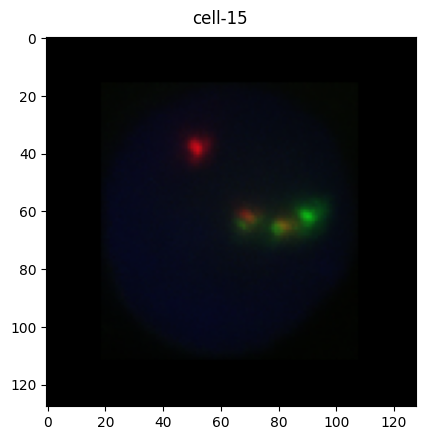

In [94]:
# raw cell rois
plt.imshow(cell_rois[15])
plt.text(50, -5, f"cell-15", fontsize=12)

Text(50, -5, 'cell-15')

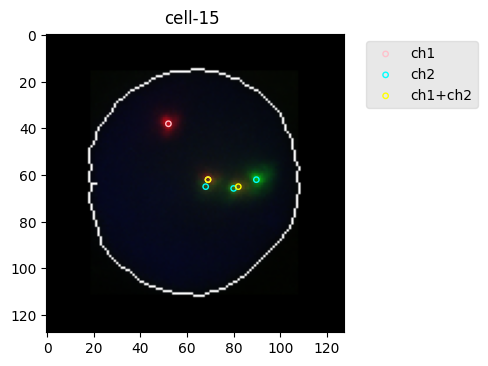

In [95]:
# cell masks + spots
i = 15
plot_cell_and_spots(cell_rois[i], cell_masks[-1, i], cell_signals[i], colors={"ch1": "pink", "ch2": "cyan", "ch1+ch2": "yellow"})
plt.tight_layout()
plt.text(50, -5, f"cell-{i}", fontsize=12)

In [97]:
cell_signals[15]

{'ch1': array([[38., 52.],
        [62., 69.]]),
 'ch2': array([[62.  , 89.75],
        [65.  , 68.  ],
        [65.75, 80.  ]]),
 'ch1+ch2': array([[62, 69],
        [65, 82]])}